In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")



In [2]:
# Load your time series data
file_path = r"C:\Users\U1078446\Downloads\hourly_sensordata(SARIMA).csv"
df = pd.read_csv(file_path)
df['time'] = pd.to_datetime(df['Datetime'])
df.set_index('time', inplace=True)

print("Dataset Info:")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Count range: {df['Count'].min():} to {df['Count'].max():}")
df.head()

Dataset Info:
Date range: 2012-08-25 00:00:00 to 2014-09-25 23:00:00
Count range: 2 to 1244


,ID,Datetime,Count
time,,,
2012-08-25 00:00:00,0,25-08-2012 00:00,8
2012-08-25 01:00:00,1,25-08-2012 01:00,2
2012-08-25 02:00:00,2,25-08-2012 02:00,6
2012-08-25 03:00:00,3,25-08-2012 03:00,2
2012-08-25 04:00:00,4,25-08-2012 04:00,2


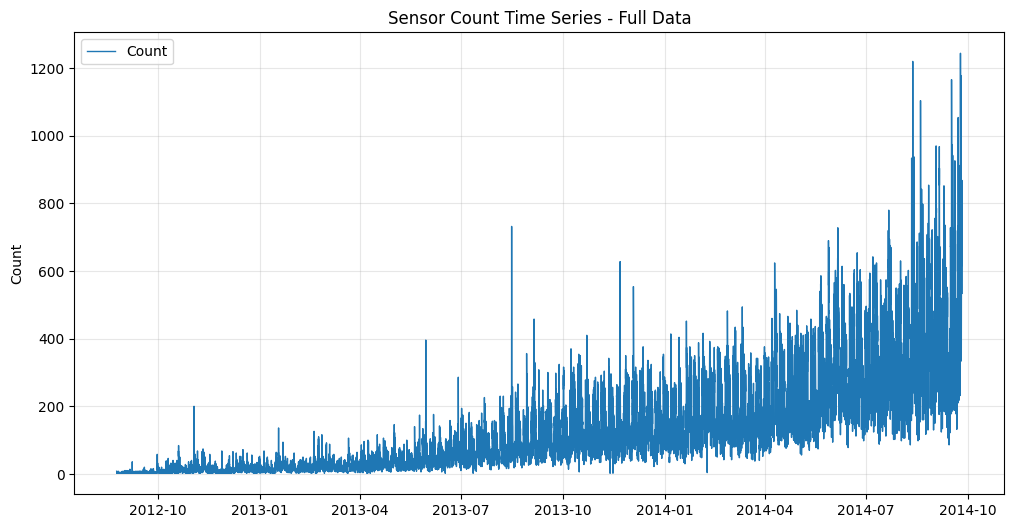

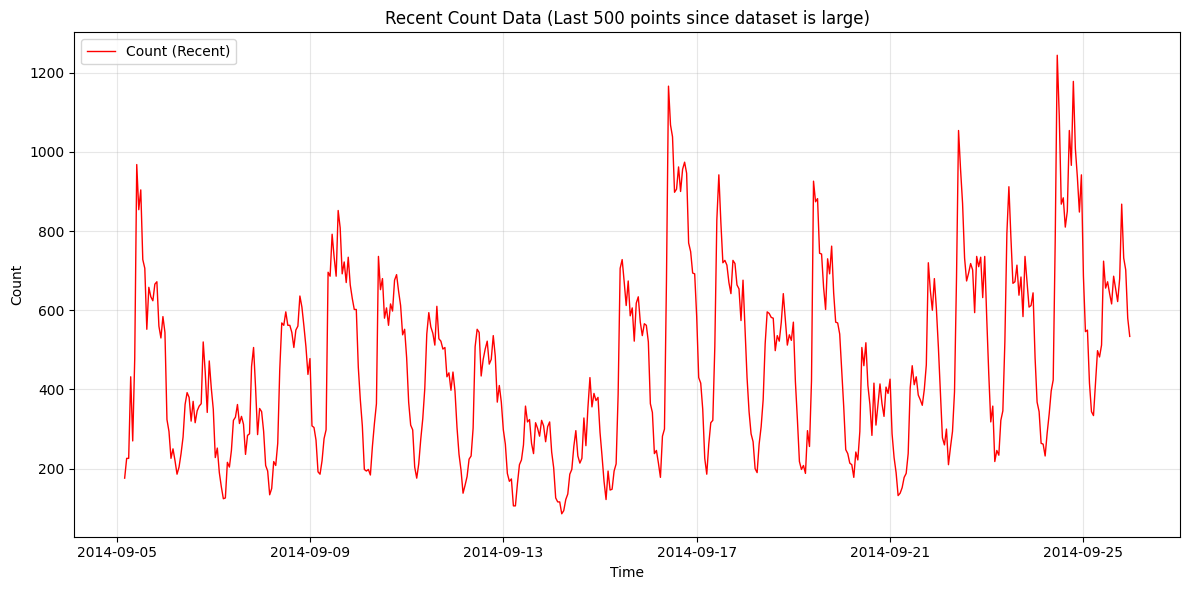

In [27]:
# Enhanced time series plot
plt.figure(figsize=(12, 6))
plt.plot(df['Count'], label='Count', linewidth=1)
plt.title('Sensor Count Time Series - Full Data')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Zoom into recent data
if len(df) > 500:
    recent_data = df.tail(500)
    plt.figure(figsize=(12, 6))
    plt.plot(recent_data['Count'], label='Count (Recent)', color='red', linewidth=1)
    plt.title('Recent Count Data (Last 500 points since dataset is large)')
    plt.ylabel('Count')
    plt.xlabel('Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Dataset is small hence zooming in on recent data is not necessary.")


In [4]:
# Test for stationarity
def check_stationarity(timeseries, title="Data"):
    result = adfuller(timeseries.dropna())
    print(f'\nStationarity Test for {title}:\n')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(" Data is stationary")
        return True
    else:
        print(" Data is not stationary - consider differencing")
        return False

In [5]:
# Check original data stationarity
is_stationary = check_stationarity(df['Count'], "Original Count")

# If not stationary, check differenced data
if not is_stationary:
    df['temp_diff'] = df['Count'].diff()
    check_stationarity(df['temp_diff'], "Differenced Count")


Stationarity Test for Original Count:

ADF Statistic: -4.456561
p-value: 0.000235
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
 Data is stationary


**ACF (Autocorrelation Function)**
Definition: ACF measures the correlation between the time series and its lagged versions.

Purpose in ARIMA:
Helps identify the MA (q) component.
If the ACF cuts off after lag q, it suggests an MA(q) process.

Interpretation:
A slow decay in ACF suggests non-stationarity.
Significant spikes at specific lags indicate correlation at those lags.

**PACF (Partial Autocorrelation Function)**
Definition: PACF measures the correlation between the time series and its lagged versions after removing the effects of intermediate lags.

Purpose in ARIMA:
Helps identify the AR (p) component.
If the PACF cuts off after lag p, it suggests an AR(p) process.

Interpretation:
Sharp cutoff in PACF after lag p indicates the order of the AR term.

**Residuals in ARIMA**
Definition: Residuals are the differences between the observed values and the values predicted by the ARIMA model.

Purpose:
Used to check the adequacy of the model.
Ideally, residuals should resemble white noise: no autocorrelation, constant variance, and zero mean.

Diagnostics:
ACF of residuals: Should show no significant autocorrelation.
Ljung-Box test: Statistical test to check if residuals are independently distributed.
Histogram and Q-Q plot: Check for normality of residuals.

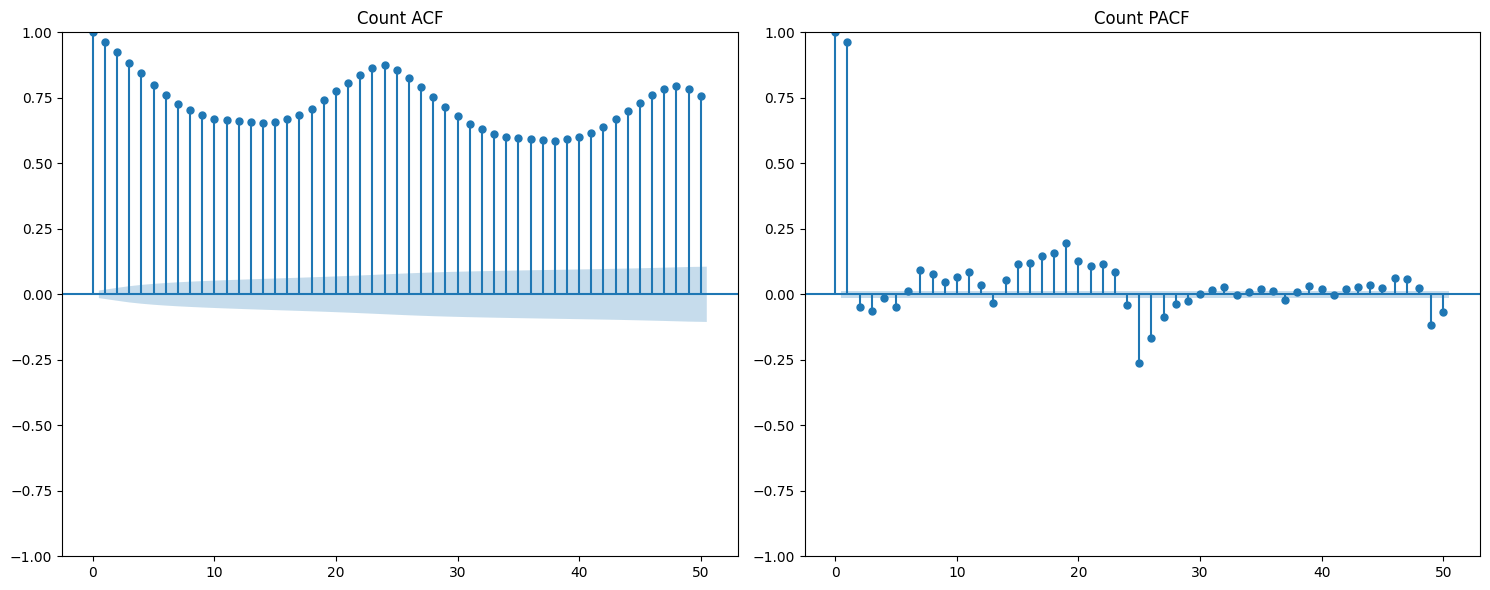

In [6]:
# Plot ACF and PACF for model identification
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plot_acf(df['Count'].dropna(), lags=50, ax=plt.gca(), title='Count ACF')
plt.subplot(1, 2, 2)
plot_pacf(df['Count'].dropna(), lags=50, ax=plt.gca(), title='Count PACF')
plt.tight_layout()
plt.show()

**Determining p (AR order) using PACF**
Look at the PACF plot: It shows the partial correlation of the time series with its own lagged values.

Rule of thumb:
If the PACF cuts off sharply after lag p (i.e., significant spikes up to lag p, then drops), it suggests an AR(p) model.

Example: If PACF has significant spikes at lags 1 and 2, and then drops, you might choose p = 2.

**Determining q (MA order) using ACF**
Look at the ACF plot: It shows the autocorrelation of the time series with its lagged values.

Rule of thumb:
If the ACF cuts off sharply after lag q, it suggests an MA(q) model.

Example: If ACF has significant spikes at lags 1 and 2, and then drops, you might choose q = 2.

**IN THIS CASE**

There is a siginificant spike at lags 1 and 2. Hence both p = 2 and q = 2

In [7]:
# Try multiple ARIMA models to find the best one
def compare_arima_models(data, orders_to_try=None):
    if orders_to_try is None:
        orders_to_try = [
            (0,1,0), (0,1,1), (0,1,2),
            (1,1,0), (1,1,1), (1,1,2),
            (2,1,0), (2,1,1), (2,1,2),
            (1,0,1), (2,0,2), (3,1,1)
        ]
    
    results = []
    print("\nComparing Different ARIMA Models:")
    
    for order in orders_to_try:
        try:
            model = ARIMA(data, order=order)
            fitted = model.fit()
            
            # Get model metrics
            aic = fitted.aic
            bic = fitted.bic
            
            # Test forecast variability
            test_forecast = fitted.forecast(steps=20)
            forecast_std = test_forecast.std()
            forecast_range = test_forecast.max() - test_forecast.min()
            
            results.append({
                'order': order,
                'aic': aic,
                'bic': bic,
                'forecast_std': forecast_std,
                'forecast_range': forecast_range,
                'model': fitted
            })
            
            print(f"ARIMA{order}: AIC={aic:.1f}, BIC={bic:.1f}, "
                  f"Forecast Range={forecast_range:.4f}, Std={forecast_std:.4f}")
            
        except Exception as e:
            print(f"ARIMA{order}: Failed - {str(e)[:60]}...")
    
    # Sort by AIC (lower is better)
    results.sort(key=lambda x: x['aic'])
    return results

**AIC (Akaike Information Criterion)** is a key metric used to evaluate and compare statistical models, especially in time series modeling like ARIMA. It helps you choose the best-fitting model among a set of candidates.

AIC = 2k - 2ln(L)  |  k = number of parameters in the model , L = maximum value of the likelihood function for the model

AIC balances model fit and model complexity.
**Lower AIC = better model (among the models being compared).**
It penalizes models with more parameters to avoid overfitting.AIC is relative, not absolute. It only tells you which model is better among those you’ve tested.
It doesn’t guarantee that the model is good—just that it’s better than the others in terms of trade-off between fit and complexity.

**BIC (Bayesian Information Criterion)** BIC helps in model selection. It penalizes model complexity more heavily than AIC, especially as the sample size increases. 

BIC = ln(n)k - 2ln(L) | n = number of observations, k = number of parameters, L = likelihood of the model

**Lower BIC = better model (among those compared).**
BIC tends to favor simpler models when data size is large.

**Difference from AIC:**

AIC is more flexible and may prefer slightly more complex models.
BIC is stricter and often leads to more parsimonious models.


**Forecast Range**
Definition: The forecast range refers to how far into the future you're predicting using your ARIMA model.


In [8]:
# Compare models
model_results = compare_arima_models(df['Count'])


Comparing Different ARIMA Models:
ARIMA(0, 1, 0): AIC=187750.2, BIC=187758.1, Forecast Range=0.0000, Std=0.0000
ARIMA(0, 1, 1): AIC=187737.7, BIC=187753.3, Forecast Range=0.0000, Std=0.0000
ARIMA(0, 1, 2): AIC=187705.6, BIC=187729.1, Forecast Range=1.7228, Std=0.3852
ARIMA(1, 1, 0): AIC=187736.4, BIC=187752.1, Forecast Range=0.0410, Std=0.0091
ARIMA(1, 1, 1): AIC=187724.2, BIC=187747.6, Forecast Range=2.7080, Std=0.6418
ARIMA(1, 1, 2): AIC=187701.4, BIC=187732.6, Forecast Range=0.6709, Std=0.1179
ARIMA(2, 1, 0): AIC=187704.3, BIC=187727.7, Forecast Range=2.6439, Std=0.5935
ARIMA(2, 1, 1): AIC=187700.9, BIC=187732.1, Forecast Range=0.5391, Std=0.0971
ARIMA(2, 1, 2): AIC=187700.3, BIC=187739.4, Forecast Range=2.2764, Std=0.4066
ARIMA(1, 0, 1): AIC=187404.5, BIC=187435.7, Forecast Range=199.7651, Std=62.0288
ARIMA(2, 0, 2): AIC=187319.3, BIC=187366.2, Forecast Range=228.8289, Std=69.5411
ARIMA(3, 1, 1): AIC=187702.7, BIC=187741.8, Forecast Range=0.7200, Std=0.1532


In [9]:
# Get the best models
best_model = model_results[0]['model'] if model_results else None
print(f"\n🏆 Best Model: ARIMA{model_results[0]['order']} (AIC: {model_results[0]['aic']:.1f})")


🏆 Best Model: ARIMA(2, 0, 2) (AIC: 187319.3)


In [10]:
# Try seasonal model if patterns suggest it
def detect_seasonality(data, max_lags=100):
   
    from statsmodels.tsa.stattools import acf
    
    autocorr = acf(data.dropna(), nlags=max_lags)
    
    # Look for significant peaks
    significant_lags = []
    threshold = 0.1  # Adjust based on your data
    
    for i in range(2, len(autocorr)):
        if abs(autocorr[i]) > threshold:
            significant_lags.append(i)
    
    return significant_lags[:5]  # Return first 5 significant lags

In [20]:
# Check for seasonality
seasonal_lags = detect_seasonality(df['Count'])
print(f"\nPotential seasonal periods detected: {seasonal_lags}")

# Try SARIMA if seasonality detected
best_sarima = None
if seasonal_lags:
    # Try the most promising seasonal period
    seasonal_period = seasonal_lags[0] if seasonal_lags else 24
    
    print(f"\nTrying SARIMA with seasonal period = {seasonal_period}:\n")
    
    sarima_orders = [
        ((1,1,1), (1,1,1,seasonal_period)),
        ((1,1,0), (1,0,0,seasonal_period)),
        ((2,1,2), (1,1,1,seasonal_period)),
        ((0,1,1), (0,1,1,seasonal_period))
    ]
    
    best_sarima_aic = float('inf')
    
    for order, seasonal_order in sarima_orders:
        try:
            sarima_model = SARIMAX(df['Count'], 
                                  order=order, 
                                  seasonal_order=seasonal_order)
            sarima_fitted = sarima_model.fit(disp=False)
            
            if sarima_fitted.aic < best_sarima_aic:
                best_sarima_aic = sarima_fitted.aic
                best_sarima = sarima_fitted
                best_sarima_order = (order, seasonal_order)
            
            print(f"SARIMA{order}×{seasonal_order}: AIC={sarima_fitted.aic:.1f}")
            
        except Exception as e:
            print(f"SARIMA{order}×{seasonal_order}: Failed")
    
    if best_sarima:
        print(f"Best SARIMA: {best_sarima_order} (AIC: {best_sarima_aic:.1f})")


Potential seasonal periods detected: [2, 3, 4, 5, 6]

Trying SARIMA with seasonal period = 2:

SARIMA(1, 1, 1)×(1, 1, 1, 2): AIC=186562.4
SARIMA(1, 1, 0)×(1, 0, 0, 2): AIC=187704.0
SARIMA(2, 1, 2)×(1, 1, 1, 2): Failed
SARIMA(0, 1, 1)×(0, 1, 1, 2): AIC=187672.7
Best SARIMA: ((1, 1, 1), (1, 1, 1, 2)) (AIC: 186562.4)


In [12]:
# Make forecasts with both models
forecast_steps = 100
print(f"\n Making {forecast_steps}-step Forecasts")

# Original simple model
simple_model = ARIMA(df['Count'], order=(1,1,1)).fit()
simple_forecast = simple_model.forecast(steps=forecast_steps)
simple_ci = simple_model.get_forecast(steps=forecast_steps).conf_int()


 Making 100-step Forecasts


In [13]:
# Best ARIMA model
best_forecast = best_model.forecast(steps=forecast_steps)
best_ci = best_model.get_forecast(steps=forecast_steps).conf_int()


In [14]:
# SARIMA model (if available)
if best_sarima:
    sarima_forecast = best_sarima.forecast(steps=forecast_steps)
    sarima_ci = best_sarima.get_forecast(steps=forecast_steps).conf_int()

In [15]:
# Create future time index
last_time = df.index[-1]
time_freq = pd.infer_freq(df.index)
if time_freq is None:
    # Estimate frequency from data
    time_diff = df.index[1] - df.index[0]
    future_times = pd.date_range(start=last_time + time_diff, 
                                periods=forecast_steps, 
                                freq=time_diff)
else:
    future_times = pd.date_range(start=last_time, 
                                periods=forecast_steps + 1, 
                                freq=time_freq)[1:]


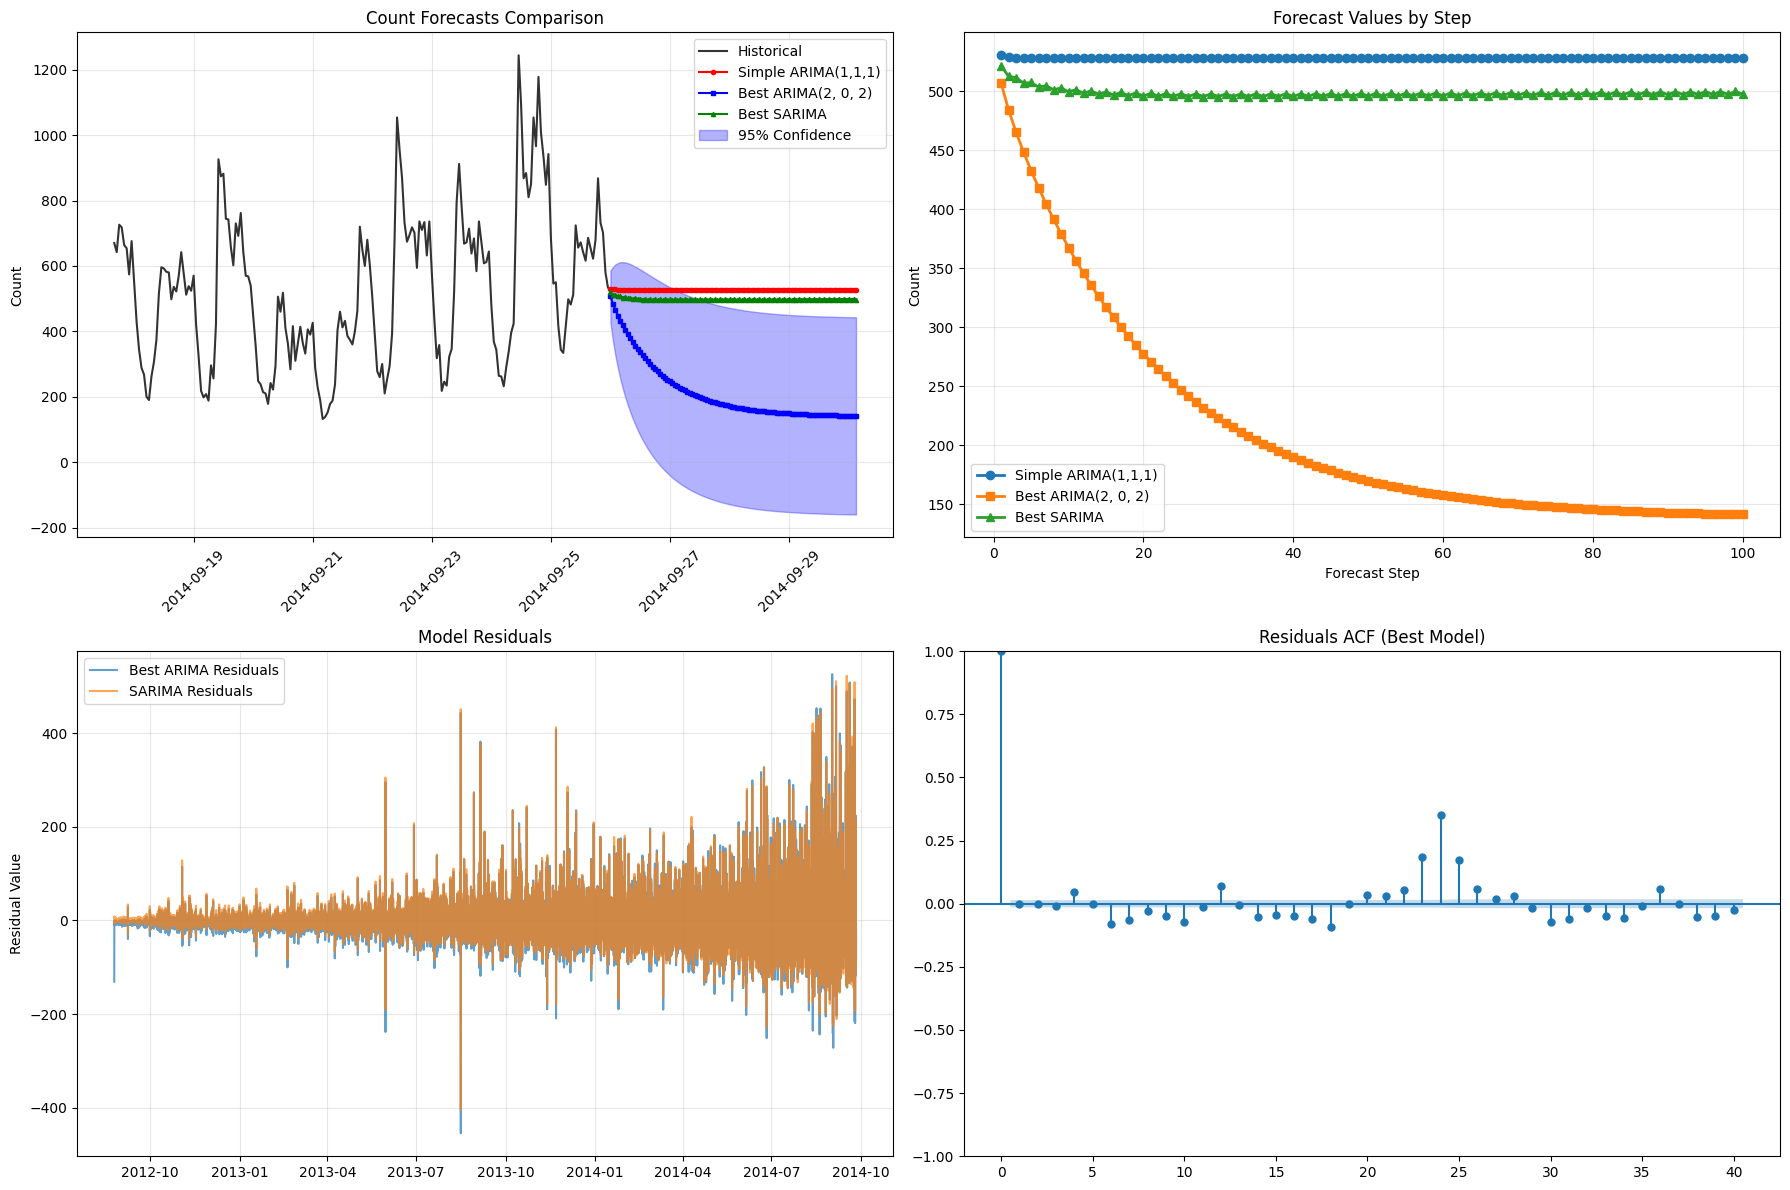

In [16]:
# Plot comprehensive forecast comparison
plt.figure(figsize=(18, 12))

# Plot 1: Recent data + forecasts
plt.subplot(2, 2, 1)
recent_points = 200
recent_data = df.tail(recent_points)
plt.plot(recent_data.index, recent_data['Count'], 
         label='Historical', color='black', alpha=0.8)
plt.plot(future_times, simple_forecast, 
         label=f'Simple ARIMA(1,1,1)', color='red', marker='o', markersize=3)
plt.plot(future_times, best_forecast, 
         label=f'Best ARIMA{model_results[0]["order"]}', color='blue', marker='s', markersize=3)

if best_sarima:
    plt.plot(future_times, sarima_forecast, 
             label='Best SARIMA', color='green', marker='^', markersize=3)

plt.fill_between(future_times, best_ci.iloc[:, 0], best_ci.iloc[:, 1], 
                alpha=0.3, color='blue', label='95% Confidence')
plt.title('Count Forecasts Comparison')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 2: Forecast details
plt.subplot(2, 2, 2)
plt.plot(range(1, forecast_steps+1), simple_forecast, 
         'o-', label=f'Simple ARIMA(1,1,1)', linewidth=2)
plt.plot(range(1, forecast_steps+1), best_forecast, 
         's-', label=f'Best ARIMA{model_results[0]["order"]}', linewidth=2)
if best_sarima:
    plt.plot(range(1, forecast_steps+1), sarima_forecast, 
             '^-', label='Best SARIMA', linewidth=2)

plt.title('Forecast Values by Step')
plt.xlabel('Forecast Step')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Model residuals comparison
plt.subplot(2, 2, 3)
plt.plot(best_model.resid, alpha=0.7, label='Best ARIMA Residuals')
if best_sarima:
    plt.plot(best_sarima.resid, alpha=0.7, label='SARIMA Residuals')
plt.title('Model Residuals')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Residuals ACF
plt.subplot(2, 2, 4)
plot_acf(best_model.resid, lags=40, ax=plt.gca(), title='Residuals ACF (Best Model)')

plt.tight_layout()
plt.show()

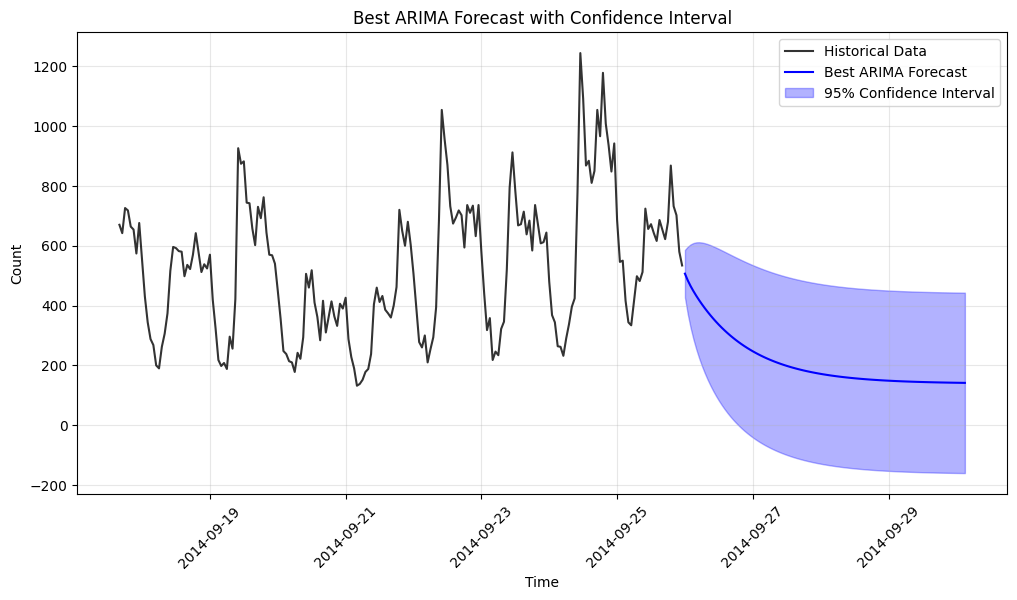

In [17]:
plt.figure(figsize=(12,6))
plt.plot(recent_data.index, recent_data['Count'], label='Historical Data', color='black', alpha=0.8)
plt.plot(future_times, best_forecast, label='Best ARIMA Forecast', color='blue')
plt.fill_between(future_times, best_ci.iloc[:, 0], best_ci.iloc[:, 1], 
                 alpha=0.3, color='blue', label='95% Confidence Interval')
plt.title('Best ARIMA Forecast with Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Count') 
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.show()

In [18]:
# Print detailed forecast summary
print("FORECAST SUMMARY")

models_summary = [
    ("Simple ARIMA(1,1,1)", simple_forecast),
    (f"Best ARIMA{model_results[0]['order']}", best_forecast)
]

if best_sarima:
    models_summary.append(("Best SARIMA", sarima_forecast))

for name, forecast in models_summary:
    print(f"\n{name}:\n")
    print(f"Mean forecast: {forecast.mean():.3f}")
    print(f"Min forecast:  {forecast.min():.3f}")
    print(f"Max forecast:  {forecast.max():.3f}")
    print(f"Range:         {forecast.max() - forecast.min():.3f}")
    print(f"Std deviation: {forecast.std():.3f}")
    
    if forecast.std() < 0.001:
        print(f"WARNING: Very flat forecast (std < 0.001)")
    else:
        print(f"Good forecast variation")

FORECAST SUMMARY

Simple ARIMA(1,1,1):

Mean forecast: 527.632
Min forecast:  527.585
Max forecast:  530.293
Range:         2.708
Std deviation: 0.297
Good forecast variation

Best ARIMA(2, 0, 2):

Mean forecast: 212.213
Min forecast:  141.520
Max forecast:  506.565
Range:         365.045
Std deviation: 91.344
Good forecast variation

Best SARIMA:

Mean forecast: 498.390
Min forecast:  495.317
Max forecast:  521.396
Range:         26.079
Std deviation: 3.751
Good forecast variation


In [19]:
# Print first few forecast values
print(f"\nDetailed Forecasts (First 10 steps):")
for i in range(min(10, len(best_forecast))):
    print(f"Step {i+1:2d}: {best_forecast.iloc[i]:7.3f} "
          f"[{best_ci.iloc[i, 0]:6.3f}, {best_ci.iloc[i, 1]:6.3f}]")

print("RECOMMENDATIONS:")

if best_forecast.std() < 0.01:
    print(" Your forecasts are quite flat. Consider:")
    print("• Using SARIMA with seasonal components")
    print("• Trying different model orders")
    print("• Checking if your data has trends or cycles")
else:
    print("The forecasts show good variation.")

if best_sarima and best_sarima.aic < best_model.aic:
    print("SARIMA model outperforms regular ARIMA - use seasonal model!")
else:
    print("Regular ARIMA seems sufficient for your data")

print("\nModel Performance Ranking:")
all_models = [(f"ARIMA{model_results[0]['order']}", model_results[0]['aic'])]
if best_sarima:
    all_models.append(("Best SARIMA", best_sarima.aic))

all_models.sort(key=lambda x: x[1])
for i, (name, aic) in enumerate(all_models, 1):
    print(f"{i}. {name} (AIC: {aic:.1f})")


Detailed Forecasts (First 10 steps):
Step  1: 506.565 [427.105, 586.026]
Step  2: 484.034 [371.339, 596.729]
Step  3: 465.103 [325.888, 604.318]
Step  4: 448.246 [287.490, 609.002]
Step  5: 432.739 [254.198, 611.280]
Step  6: 418.231 [224.787, 611.675]
Step  7: 404.541 [198.449, 610.633]
Step  8: 391.570 [174.629, 608.511]
Step  9: 379.253 [152.926, 605.580]
Step 10: 367.547 [133.043, 602.051]
RECOMMENDATIONS:
The forecasts show good variation.
SARIMA model outperforms regular ARIMA - use seasonal model!

Model Performance Ranking:
1. Best SARIMA (AIC: 186562.4)
2. ARIMA(2, 0, 2) (AIC: 187319.3)
